# Self implemented Feed Forward (Dense) Neural Net (FFNN)

In [1]:
# Imports
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

In [2]:
# Define different activation functions

tanh = np.tanh
tanh_derivative = lambda x: 1 - np.tanh(x)**2
sigmoid = lambda x: 1/(1+np.exp(-x))
sigmoid_derivative = lambda x: -sigmoid(x) * (1-sigmoid(x))
relu = np.vectorize(lambda x: x if x>0 else 0)
relu_derivative = np.vectorize(lambda x: 1 if x>0 else 0)

In [3]:
# Definition of My dense Neural Network

class MyDenseNN:
    def __init__(self, shape, learning_rate):
        self.shape = shape
        self.alist = [np.empty(s) for s in shape]
        self.zlist = [np.empty(s) for s in shape] # zlist [0] is unused
        
        self.agrads = [np.empty(s) for s in shape]
        
        self.weights = [npr.normal(size=(shape[i],shape[i+1])) for i in range(len(shape)-1)]
        self.wgrads = [npr.normal(size=(shape[i],shape[i+1])) for i in range(len(shape)-1)]
        self.biases = [npr.normal(size=s) for s in shape[1:]]
        self.bgrads = [np.empty(s) for s in shape[1:]]

        self.act = tanh
        self.act_prime = tanh_derivative
        self.loss = np.nan
        self.loss_history = []
        self.learning_rate = learning_rate

    def fProp(self, X):
        result = np.empty((len(X), self.shape[-1]))
        for i,x in enumerate(X):
            result[i] = self.fProp_sample(x)
        
        return result

    def fProp_sample(self, x):
        if len(x) != self.shape[0]:
            raise Exception(f"cannot forward propagate with given input len {len(x)}")

        self.alist[0][:] = x
        for i in range(len(self.shape)-1):
            j = i+1
            self.zlist[j][:] = np.dot(self.alist[i], self.weights[i]) + self.biases[i]
            self.alist[j][:] = self.act(self.zlist[j])

        return self.alist[-1]
    
    def bProp(self, x, y, y_hat):
        self.loss += np.sum((y_hat-y)**2)
        
        self.agrads[-1][:] = 2*(y_hat - y)
        for i in range(len(self.alist))[-2:0:-1]:
            j = i+1
            self.agrads[i] = np.einsum("k,ik", self.agrads[j]*self.act_prime(self.zlist[j]), self.weights[i])

        for i in range(len(self.wgrads))[::-1]:
            j = i+1
            self.wgrads[i] = np.einsum("j,i", self.agrads[j]*self.act_prime(self.zlist[j]),self.alist[i])
            self.bgrads[i] = self.agrads[j]*self.act_prime(self.zlist[j])
    
    def reset_loss(self):
        self.loss = 0
    
    def fit_sample(self, x, y, add_grads=True):
        if add_grads:
            self.reset_loss()

        y_hat = self.fProp_sample(x)
        self.bProp(x,y,y_hat)

        if add_grads:
            for i in range(len(self.shape)-1):
                self.weights[i] -= self.learning_rate*self.wgrads[i]
                self.biases[i] -= self.learning_rate*self.bgrads[i]
    
    def fit_batch(self, X_batch, Y_batch):
        for i in range(len(X_batch)):
            self.fit_sample(X_batch[i], Y_batch[i], add_grads=False)

        for i in range(len(self.shape)-1):
            self.weights[i] -= self.learning_rate*self.wgrads[i]
            self.biases[i] -= self.learning_rate*self.bgrads[i]
        self.loss_history.append(self.loss)
        self.reset_loss()
        
    def fit(self,X,Y,batchsize,epochs=1):
        assert len(X) == len(Y), f"data and label should have same length but have length {len(X)} and {len(Y)}"
        rnd_idx = np.arange(len(X)); npr.shuffle(rnd_idx)
        for ep in range(epochs):
#             print(f"epoch: {ep+1}/{epochs}")
            for b in range(len(X)//batchsize):
                start = b*batchsize
                end = (b+1)*batchsize
                end = end if end <= len(X) else len(X)
                batch_idx = rnd_idx[start:end]
                self.fit_batch(X[batch_idx], Y[batch_idx])

out before training:  [[-0.36868612 -0.10918944]]
out after training:  [[0.5 0.4]]


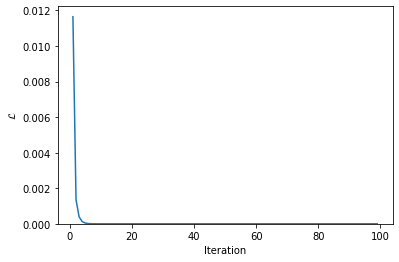

In [4]:
# Test NN

sample = npr.rand(5).reshape(1,5)
out = np.array([0.5,0.4]).reshape(1,2)
iters = 100
loss = np.empty(iters)

nn = MyDenseNN([5,3,2], learning_rate=0.1)
print("out before training: ", nn.fProp(sample))

nn.fit(sample, out, batchsize=1, epochs=iters)
# for i in range(iters):
#     loss[i] = nn.loss
    

print("out after training: ", nn.fProp(sample))

plt.plot(range(len(nn.loss_history)), nn.loss_history)
plt.ylim(0,None)
plt.xlabel("Iteration")
plt.ylabel(r"$\mathcal{L}$")

plt.show()

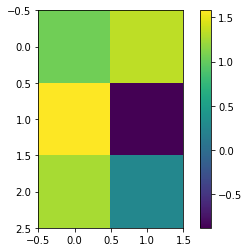

In [5]:
# Show weights

plt.imshow(nn.weights[1])
plt.colorbar()

plt.show()